In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scalarhadronizer import ScalarHadronizer
from particle import Particle as p
#using the hipsofcobra code to generate pi+pi- and K+K- decay widths, see https://arxiv.org/pdf/2407.13587
from hipsofcobra import HipsofCobra

# pi and K decay widths from literature

In [56]:
#hips_pi = HipsofCobra( clist=[1,1,1], Pname='pi', method='DGL')
#hips_pi.write_widths()
pi_data=np.loadtxt('/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/results/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_pi_method=DGL.csv',delimiter=',',skiprows=1)
m=pi_data[:,0]
pi_width=pi_data[:,1]
pi_width_2GeV=pi_width[m==2.0][0]
print(pi_width_2GeV)

5.008185005808889e-08


In [57]:
#hips_K = HipsofCobra( clist=[1,1,1], Pname='K', method='DGL')
#hips_K.write_widths()
K_data=np.loadtxt('/home/henry/Documents/Uni/Masterarbeit/code/owndecayer/results/clist=[1, 1, 1]/widths_data_c=[1, 1, 1]_K_method=DGL.csv',delimiter=',',skiprows=1)
m=K_data[:,0]
K_width=K_data[:,1]
K_width_2GeV=K_width[m==2.0][0]
print(K_width_2GeV)

1.310270241863413e-07


In [58]:
#from own calculation of gluonic decay width
hadronic_decay_width_2GeV=1.5294102825483557e-07
hadronic_decay_width_2GeV= 3.8896142800792654e-07

pi_branching_ratio=pi_width_2GeV/hadronic_decay_width_2GeV
print(f'Pi branching ratio: {pi_branching_ratio}')
K_branching_ratio=K_width_2GeV/hadronic_decay_width_2GeV
print(f'K branching ratio: {K_branching_ratio}')
print(f'Sum: {pi_branching_ratio+K_branching_ratio}')

Pi branching ratio: 0.12875788304918576
K branching ratio: 0.3368637986995233
Sum: 0.4656216817487091


# Ratio of down and strange weight from data
$\Gamma_\pi/\Gamma_K = \frac{2p(\pi)w_d}{3p(K)w_s}$
so $w_d/w_s$ is:

In [5]:
def p_restframe(M,m1,m2):
    return np.sqrt((M**2-(m1+m2)**2)*(M**2-(m1-m2)**2))/2/M

K=p.findall('K+')[0]
pi=p.findall('pi0')[0]
K.mass
print(3*p_restframe(2000,K.mass,K.mass)*pi_width_2GeV/(2*p_restframe(2000,pi.mass,pi.mass)*K_width_2GeV))

0.503205697784993


# Fit parameters

In [6]:
def fit_parameters():
    SH=ScalarHadronizer(2000)
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    up_weights=np.linspace(1,50,10)
    OAM_supression_pars=[2,1,0.5,0.2,0.1]
    for OAM_supression_par in OAM_supression_pars:
        for up_weight in up_weights:
            down_weights=np.arange(1,up_weight,1)
            strange_weights=2*down_weights
            for down_weight,strange_weight in zip(down_weights,strange_weights):
                SH.set_parameters(OAM_supression_par,up_weight,down_weight,strange_weight,charm_weight=1,bottom_weight=1)
                meson_pairs={}
                total_weight=0
                for i,m1 in enumerate(mesons_below_threshold):
                    for m2 in mesons_below_threshold[i:]:
                        if SH.check_meson_combinations(m1,m2,2000):
                            weight=SH.initialWeight(m1,m2)
                            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
                            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
                            total_weight+=weight
                    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
                init_pairs=SH.make_initialMesonPairs()
                if (-211,211) in init_pairs or (211,-211) in init_pairs:
                    pi_fit=init_pairs[(-211,211)]
                if (-321,321) in init_pairs or (321,-321) in init_pairs:
                    K_fit=init_pairs[(-321,321)]

                print('------------------------------------')
                print(f'pi_fit: {pi_fit}, K_fit: {K_fit}')
                print(f'Ratio: {pi_fit/K_fit}')
                print(f'up_weight: {up_weight}, down_weight: {down_weight}, strange_weight: {strange_weight}, OAM_supression_par: {OAM_supression_par}')
                err_pi=np.abs(1-pi_fit/pi_branching_ratio)
                err_K=np.abs(1-K_fit/K_branching_ratio)
                print(f'Error pi: {err_pi}, Error K: {err_K}')
                print(f'------------------------------------')
                print('\n')
                if err_pi<5e-2 and err_K<5e-2:
                    return up_weight,down_weight,strange_weight,OAM_supression_par
    return None

up_weight_fit,down_weight_fit,strange_weight_fit,OAM_supression_par_fit=fit_parameters()

------------------------------------
pi_fit: 0.03409139777804529, K_fit: 0.09072872151898563
Ratio: 0.3757508891041898
up_weight: 6.444444444444445, down_weight: 1.0, strange_weight: 2.0, OAM_supression_par: 2
Error pi: 0.7352286557474519, Error K: 0.7306664537143865
------------------------------------


------------------------------------
pi_fit: 0.046233184139089174, K_fit: 0.12304211508138156
Ratio: 0.3757508891041899
up_weight: 6.444444444444445, down_weight: 2.0, strange_weight: 4.0, OAM_supression_par: 2
Error pi: 0.6409292926831671, Error K: 0.6347422443242914
------------------------------------


------------------------------------
pi_fit: 0.050486566531336874, K_fit: 0.13436180191535818
Ratio: 0.37575088910418986
up_weight: 6.444444444444445, down_weight: 3.0, strange_weight: 6.0, OAM_supression_par: 2
Error pi: 0.6078953355263622, Error K: 0.6011390881594654
------------------------------------


------------------------------------
pi_fit: 0.05146580730330256, K_fit: 0.1

# Scalar resonances?

In [ ]:
scalar_resonances=p.findall(lambda p: p.J==0 and p.C==1 and p.P==1 and p.I==0)
for s in scalar_resonances:
    print(s.name)
    dec=SH.single_particle_decays(s.pdgid)
    if (-211,211) in dec:
        print(f'pi+pi- br: {dec[(-211,211)]}')
    if (211,-211) in dec:
        print(f'pi+pi- br: {dec[(211,-211)]}')

    if (-321,321) in dec:
        print(f'K+K- br: {dec[(-321,321)]}')
    if (321,-321) in dec:
        print(f'K+K- br: {dec[(321,-321)]}')


f(0)(1370)
pi+pi- br: 0.5200000000000001
K+K- br: 0.03500000000000001
f(0)(1710)
chi(c0)(1P)
chi(b0)(1P)
chi(b0)(2P)
f(0)(500)
f(0)(980)
pi+pi- br: 0.6667
f(0)(1500)
pi+pi- br: 0.23300000000000004
K+K- br: 0.043000000000000003
f(0)(2020)


Since the widths of f(1370) and f(1500) are not very big (from pdg) they shouldnt affect the pi+pi- or K+K- brs too much, so its probably unnecessary to implement resonances in the model. Note: pdg doesn't list the branching ratios above for f(1370)

# Plot branching ratios

In [7]:
SH=ScalarHadronizer(2000,up_weight=up_weight_fit,down_weight=down_weight_fit,strange_weight=strange_weight_fit,OAM_supression_par=OAM_supression_par_fit) 
decay_graph=SH.simulateDecay()
print('\n')
SH.print_initial_states()
SH.print_final_states(10,decay_graph)

Building decay graph...
Generated 22 initial meson pairs.
Generated decay graph with 254 nodes and 383 edges.
Building weights...
254 of 254 nodes done

Done


The following initial states were generated:
K- K+: 0.32835002343059816
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K(0)*(700)- K(0)*(700)+: 0.20191050321199439
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
pi- pi+: 0.12337781324142882
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: -1 -1
K~0 K0: 0.05836675917488185
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
eta eta: 0.05264355994275247
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
eta eta'(958): 0.04054143281907074
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.03598405007738514
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
K*(892)- K*(892)+: 0.03418392541815803
	 J: 1.0 1.0, I: 0.5 0.5, C: 5 5, P: -1 -1
a(0)(980)- a(0)(980)+: 0.024794560221920704
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: 1 1
eta eta(1295): 0.022754048830717126
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
rho(770)- rho

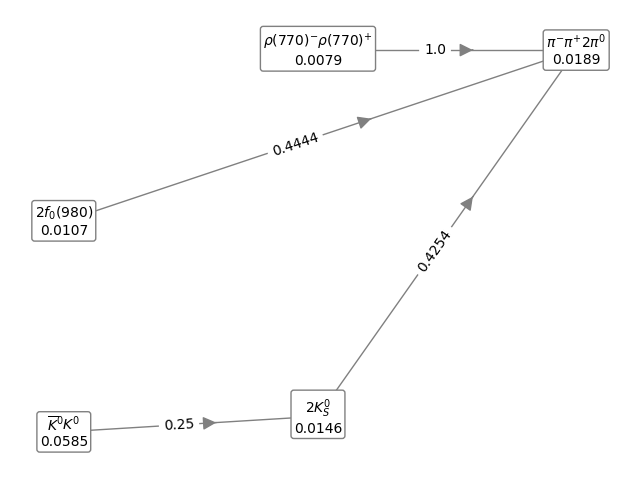

In [140]:
SH.plot_from_final_state(decay_graph,(-211,111,111,211))

In [8]:
masses=np.linspace(2000,5000,15)
pi_br=np.zeros(len(masses))
K_br=np.zeros(len(masses))
four_pi1=np.zeros(len(masses))
four_pi2=np.zeros(len(masses))
most_common_br=np.zeros((10,len(masses)))
brs=[]
for i,m in enumerate(masses):
    SH=ScalarHadronizer(m,up_weight=up_weight_fit,down_weight=down_weight_fit,strange_weight=strange_weight_fit,OAM_supression_par=OAM_supression_par_fit) 
    decay_graph=SH.simulateDecay()
    final_states=SH.get_most_common_final_states(decay_graph)
    brs.append(final_states)


Building decay graph...
Generated 22 initial meson pairs.
Generated decay graph with 254 nodes and 383 edges.
Building weights...
254 of 254 nodes done

Done
Building decay graph...
Generated 28 initial meson pairs.
Generated decay graph with 347 nodes and 564 edges.
Building weights...
347 of 347 nodes done

Done
Building decay graph...
Generated 37 initial meson pairs.
Generated decay graph with 467 nodes and 815 edges.
Building weights...
467 of 467 nodes done

Done
Building decay graph...
Generated 60 initial meson pairs.
Generated decay graph with 918 nodes and 1939 edges.
Building weights...
918 of 918 nodes done

Done
Building decay graph...
Generated 80 initial meson pairs.
Generated decay graph with 1172 nodes and 2638 edges.
Building weights...
1172 of 1172 nodes done

Done
Building decay graph...
Generated 100 initial meson pairs.
Generated decay graph with 1334 nodes and 3037 edges.
Building weights...
1334 of 1334 nodes done

Done
Building decay graph...
Generated 113 init

In [13]:
pi_br=[f[(-211,211)] for f in brs if (-211,211) in f]
K_br=[f[(-321,321)] for f in brs if (-321,321) in f]
four_pi1=[f[(-211,111,111,211)] for f in brs if (-211,111,111,211) in f]

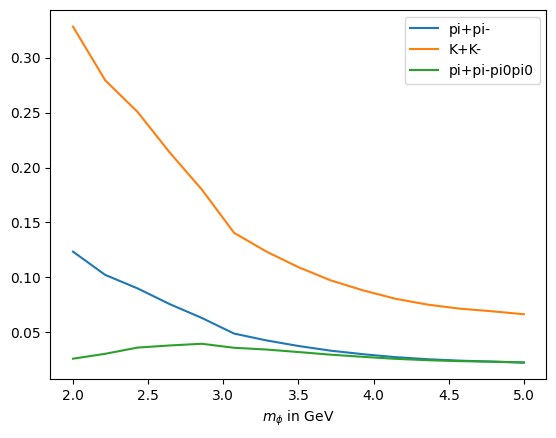

In [14]:
plt.plot(masses*1e-3,pi_br,label='pi+pi-')
plt.plot(masses*1e-3,K_br,label='K+K-')
plt.plot(masses*1e-3,four_pi1,label='pi+pi-pi0pi0')
#plt.plot(masses*1e-3,four_pi2,label='4pi0')
plt.xlabel(r'$m_\phi$ in GeV')
plt.legend()

In [26]:
from particle import Particle as p
k=p.findall('K+')[0]
pi=p.findall('pi0')[0]
k.pdgid.has_strange
pi.pdgid.has_down
eta=p.findall('eta')[0]
eta.quarks

'x(uU+dD)+y(sS)'

In [110]:
SH=ScalarHadronizer(2000,OAM_supression_par=1,up_weight=1,down_weight=1,strange_weight=1)
SH.print_initial_states()

The following initial states were generated:
eta eta: 0.10566557281557871
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
eta eta'(958): 0.0813743167492831
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
omega(782) omega(782): 0.0786205321854996
	 J: 1.0 1.0, I: 0.0 0.0, C: -1 -1, P: -1 -1
K- K+: 0.054921712088386546
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K~0 K0: 0.054779928858596616
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
omega(782) phi(1020): 0.05439375698747177
	 J: 1.0 1.0, I: 0.0 0.0, C: -1 -1, P: -1 -1
eta f(1)(1285): 0.04744928898270968
	 J: 0.0 1.0, I: 0.0 0.0, C: 1 1, P: -1 1
eta eta(1295): 0.0456716758172503
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
pi0 pi0: 0.04130029918301476
	 J: 0.0 0.0, I: 1.0 1.0, C: 1 1, P: -1 -1
pi- pi+: 0.04127376429667116
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: -1 -1
eta'(958) eta'(958): 0.03631390443252116
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.033772711234096475
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
K(0)*(700)- K(0)*(

In [89]:
up_weigth=28
down_weight=5
strange_weight=2*down_weight
OAM_supression_par=0.1
SH=ScalarHadronizer(2000,OAM_supression_par=OAM_supression_par,up_weight=up_weigth,down_weight=down_weight,strange_weight=strange_weight)

initial_states=SH.make_initialMesonPairs()
print('The following initial states were generated:')
sorted_states = dict(sorted(initial_states.items(), key=lambda item: item[1], reverse=True))
for key, value in sorted_states.items():
    p1=p.from_pdgid(key[0])
    p2=p.from_pdgid(key[1])
    print(f'{p1.name} {p2.name}: {value}')
    print(f'\t J: {p1.J} {p2.J}, I: {p1.I} {p2.I}, C: {p1.C} {p2.C}, P: {p1.P} {p2.P}')

gamma_pi=initial_states[(-211,211)]
gamma_K=initial_states[(-321,321)]
print('\n')
print(f'Simulated pi+pi- branching ratio: {gamma_pi}, calculated branching ratio: {pi_width_2GeV/hadronic_decay_width_2GeV}')
print(f'Simulated K+K- branching ratio: {gamma_K}, calculated branching ratio: {K_width_2GeV/hadronic_decay_width_2GeV}')
print(f'Ratio: {gamma_pi/gamma_K}')

<PDGID: 211> <PDGID: -211>
990.2121521347068 140 1 0.33
28 5 10
<PDGID: 321> <PDGID: -321>
869.6453413150674 280 1 0.5
28 5 10
The following initial states were generated:
K- K+: 0.33065648331760195
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
K(0)*(700)- K(0)*(700)+: 0.20332880211009588
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
pi- pi+: 0.12424446759465367
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: -1 -1
eta eta: 0.06361601885008838
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K~0 K0: 0.058893370815657695
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: -1 -1
eta eta'(958): 0.048991454172784575
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
K(0)*(700)~0 K(0)*(700)0: 0.03630871466251712
	 J: 0.0 0.0, I: 0.5 0.5, C: 5 5, P: 1 1
eta eta(1295): 0.0274966586778107
	 J: 0.0 0.0, I: 0.0 0.0, C: 1 1, P: -1 -1
a(0)(980)- a(0)(980)+: 0.02496872697839072
	 J: 0.0 0.0, I: 1.0 1.0, C: 5 5, P: 1 1
K*(892)- K*(892)+: 0.01721202338690927
	 J: 1.0 1.0, I: 0.5 0.5, C: 5 5, P: -1 -1
eta eta(1405): 0.01422781298196137
	 J: 0.0 0.0

In [68]:
pi_width_2GeV/K_width_2GeV

np.float64(0.3822253490765731)

In [15]:
import pdg
api = pdg.connect()
eta=api.get_particle_by_mcid(221)

In [23]:
eta.width

1.3076917231244102e-06

In [31]:
SH.single_particle_decays(10331)

{}

up/down weight sollten gleich sein (isospin). Quark mixtures betrachten (srangeness anteil, v.a. eta). Siehe auch herwig manual. eta eta' wie herwig, omega ohne strange, phi nur strange

In [24]:
p.findall('h(1)')

[<Particle: name="h(1)(1170)", pdgid=10223, mass=1166 ± 6 MeV>,
 <Particle: name="h(1)(1415)", pdgid=10333, mass=1409 + 9 - 8 MeV>]

In [12]:
SH=ScalarHadronizer(2000)
SH.neutral_light_meson_mixing()

{111: [0.5, 0.5, 0, 0, 0],
 221: [np.float64(0.42366459261474937),
  np.float64(0.42366459261474937),
  np.float64(0.15267081477050132),
  0,
  0],
 331: [np.float64(0.07633540738525066),
  np.float64(0.07633540738525066),
  np.float64(0.8473291852294987),
  0,
  0],
 333: [np.float64(0.42366459261474937),
  np.float64(0.42366459261474937),
  np.float64(0.15267081477050132),
  0,
  0],
 223: [np.float64(0.07633540738525066),
  np.float64(0.07633540738525066),
  np.float64(0.8473291852294987),
  0,
  0]}

In [9]:
0.5*np.cos(np.arctan(1/np.sqrt(2)))**2

np.float64(0.3333333333333333)

Identify singlets and octets to assign mixing angles

In [27]:
p.findall(lambda p: p.J==0 and p.P==-1 and p.invert()==p and p.L==0)

[<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
 <Particle: name="K(L)0", pdgid=130, mass=497.611 ± 0.013 MeV>,
 <Particle: name="eta", pdgid=221, mass=547.862 ± 0.017 MeV>,
 <Particle: name="K(S)0", pdgid=310, mass=497.611 ± 0.013 MeV>,
 <Particle: name="eta'(958)", pdgid=331, mass=957.78 ± 0.06 MeV>,
 <Particle: name="eta(c)(1S)", pdgid=441, mass=2984.1 ± 0.4 MeV>,
 <Particle: name="eta(b)(1S)", pdgid=551, mass=9398.7 ± 2.0 MeV>,
 <Particle: name="pi(1300)0", pdgid=100111, mass=1300 ± 100 MeV>,
 <Particle: name="eta(1295)", pdgid=100221, mass=1294 ± 4 MeV>,
 <Particle: name="eta(1475)", pdgid=100331, mass=1476 ± 4 MeV>,
 <Particle: name="eta(c)(2S)", pdgid=100441, mass=3637.7 ± 0.9 MeV>]

In [42]:
SH=ScalarHadronizer(2000)
decay_graph=SH.simulateDecay()
SH.print_final_states(10,decay_graph)

Building decay graph...
Generated 21 initial meson pairs.
Generated decay graph with 193 nodes and 314 edges.
Building weights...
193 of 193 nodes done

Done
The following final states were generated:
(-211, -211, 111, 111, 211, 211) pi- pi- pi0 pi0 pi+ pi+ :  0.16796008925627406
(-211, 111, 111, 211) pi- pi0 pi0 pi+ :  0.05502637882547542
(22, 22, 111, 111, 111) gamma gamma pi0 pi0 pi0 :  0.04479711486709805
(-321, -211, 111, 211, 321) K- pi- pi0 pi+ K+ :  0.04028964812156559
(-211, -211, 211, 211) pi- pi- pi+ pi+ :  0.03429098592946386
(111, 111) pi0 pi0 :  0.0335855840458642
(-211, 211) pi- pi+ :  0.03356400576015999
(-211, 22, 22, 111, 111, 111, 211) pi- gamma gamma pi0 pi0 pi0 pi+ :  0.03179387089981463
(-211, 22, 22, 111, 211) pi- gamma gamma pi0 pi+ :  0.03127683119673963
(22, 22, 100221) gamma gamma eta(1295) :  0.029429336538021635


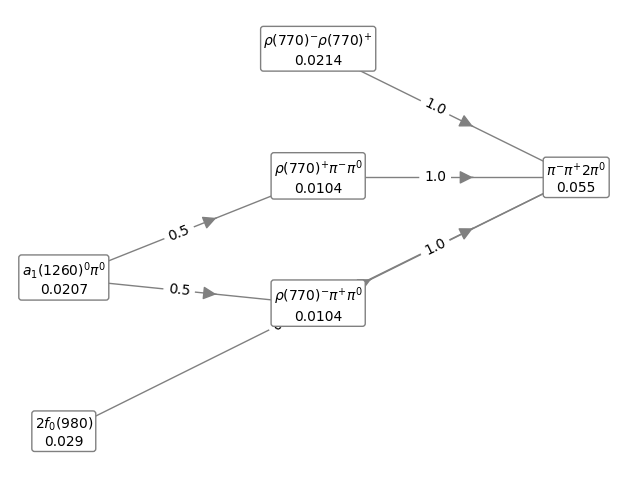

In [43]:
SH.plot_from_final_state(decay_graph,(-211,111,111,211))

In [36]:
import networkx as nx
state=(-211,111,111,211)
ancestors=nx.ancestors(decay_graph,state)
connected_initial_states=[k for k in ancestors if decay_graph.in_degree()[k]==0]

In [37]:
connected_initial_states

[(-213, 213), (111, 20113), (9010221, 9010221)]

In [40]:
def make_weight(decay_graph,state,weight=0):
    in_edges=decay_graph.in_edges(state,'weight')
    if in_edges:
        for edge in in_edges:
            weight+=make_weight(decay_graph,edge[0])*edge[2]
    else:
        weight=decay_graph.nodes[state]['weight']
    return weight

make_weight(decay_graph,(-211,111,111,211))


np.float64(0.05502637882547542)

In [39]:
decay_graph.in_edges(state,'weight')

InEdgeDataView([((-213, 213), (-211, 111, 111, 211), np.float64(1.0)), ((9010221, 9010221), (-211, 111, 111, 211), np.float64(0.44442222)), ((-213, 111, 211), (-211, 111, 111, 211), np.float64(1.0)), ((-211, 111, 213), (-211, 111, 111, 211), np.float64(1.0))])

In [45]:
final_states=SH.get_most_common_final_states(decay_graph)
for k,v in final_states.items():
    print(k,v,make_weight(decay_graph,k))

(-211, -211, 111, 111, 211, 211) 0.16796008925627406 0.16796008925627406
(-211, 111, 111, 211) 0.05502637882547542 0.05502637882547542
(22, 22, 111, 111, 111) 0.04479711486709805 0.04479711486709805
(-321, -211, 111, 211, 321) 0.04028964812156559 0.04028964812156559
(-211, -211, 211, 211) 0.03429098592946386 0.03429098592946386
(111, 111) 0.0335855840458642 0.0335855840458642
(-211, 211) 0.03356400576015999 0.03356400576015999
(-211, 22, 22, 111, 111, 111, 211) 0.03179387089981463 0.03179387089981463
(-211, 22, 22, 111, 211) 0.03127683119673963 0.03127683119673963
(22, 22, 100221) 0.029429336538021635 0.029429336538021635
(22, 22, 22, 22) 0.027033690289002522 0.027033690289002522
(-211, 111, 111, 111, 111, 211) 0.025914179396535477 0.025914179396535477
(-211, 22, 22, 22, 211) 0.0244074201515922 0.0244074201515922
(111, 111, 111, 100221) 0.024383451819978745 0.024383451819978745
(-211, 22, 111, 111, 211) 0.023314274343489847 0.023314274343489847
(-211, 22, 111, 111, 111, 211) 0.02020321

In [52]:
def weight_for_opti(decay_graph,state,up_weight,down_weight,strange_weight,OAM_supression_par,weight=0):
    in_edges=decay_graph.in_edges(state,'weight')
    if in_edges:
        for edge in in_edges:
            weight+=weight_for_opti(decay_graph,edge[0],up_weight,down_weight,strange_weight,OAM_supression_par,weight)*edge[2]
    else:
        m1=p.from_pdgid(state[0])
        m2=p.from_pdgid(state[1])
        weight=SH.initialWeight(m1,m2,up_weight,down_weight,strange_weight,0,0,OAM_supression_par)
    return weight


In [53]:
SH=ScalarHadronizer(2000,1,1,1,1,1,1)
final_states=SH.get_most_common_final_states(decay_graph)
decay_graph=SH.simulateDecay()
for k,v in final_states.items():
    print(k,v,weight_for_opti(decay_graph,k,1,1,1,1))

Building decay graph...
Generated 28 initial meson pairs.
Generated decay graph with 266 nodes and 418 edges.
Building weights...
266 of 266 nodes done

Done
(-211, -211, 111, 111, 211, 211) 0.10499753953243425 12531.616510680284
(-211, 111, 111, 211) 0.06557343031460289 2023.9328518804366
(-321, 321) 0.054921712088386546 434.8226706575337
(111, 111) 0.04130029918301476 326.9800905116176
(-211, 211) 0.04127376429667116 326.7700102044533
(-211, -211, 211, 211) 0.04082703031455528 453.4935052585636
(-9000311, 9000311) 0.033772711234096475 267.38315204963834
(-9000321, 9000321) 0.033772711234096475 267.38315204963834
(22, 22, 111, 111, 111) 0.02754357708980883 218.06624910706012
(-321, -211, 111, 211, 321) 0.02477215401594234 196.12451537958302
(111, 100111) 0.023599702818593242 186.84205965375796
(-211, 22, 22, 111, 111, 111, 211) 0.02130877269020994 4022.502080239283
(-211, 22, 22, 111, 211) 0.019230609242316635 152.25135108058174
(-211, 130, 211) 0.01898440250648911 150.30209883887974


In [98]:
SH=ScalarHadronizer(2000,1,1,1,1,1,1)

def init_make_initialMesonPairs(self,strange_weight,OAM_supression_par):
    mesons_below_threshold=p.findall(lambda p: p.mass<2000 and p.pdgid.is_meson==True)
    meson_pairs={}
    total_weight=0
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if self.check_meson_combinations(m1,m2,self.scalar_mass):
                weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
                if m1.pdgid<m2.pdgid: meson_pairs[(m1,m2)]=weight
                else: meson_pairs[(m2,m1)]=weight
                total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

def update_init_weights(self,init_meson_pairs,strange_weight,OAM_supression_par):
    meson_pairs={}
    total_weight=0
    for m1,m2 in init_meson_pairs:
            weight=self.initialWeight(m1,m2,1,1,strange_weight,0,0,OAM_supression_par)
            if m1.pdgid<m2.pdgid: meson_pairs[(int(m1.pdgid),int(m2.pdgid))]=weight
            else: meson_pairs[(int(m2.pdgid),int(m1.pdgid))]=weight
            total_weight+=weight
    meson_pairs={k:v/total_weight for k,v in meson_pairs.items()}
    return meson_pairs

meson_pairs=init_make_initialMesonPairs(SH,1,1)
def f(x):
    pairs=update_init_weights(SH,meson_pairs,x[0],x[1])
    return np.array([pairs[(-211,211)]-pi_branching_ratio,pairs[(-321,321)]-K_branching_ratio])

In [99]:
f([10,0])

array([-0.11249454, -0.12045255])

In [100]:
from scipy.optimize import fsolve
fsolve(f,[1,1])

array([ 1.96612229, -1.14257127])

In [78]:
import scipy.optimize as optimize
optimize.least_squares(f,[1,1],bounds=([0,0],[10,10]))

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.125e-01 -1.205e-01]
           x: [ 1.000e+01  1.484e-12]
        cost: 0.013581919201523154
         jac: [[-1.369e-03 -5.732e-03]
               [ 3.430e-03 -7.627e-02]]
        grad: [-2.592e-04  9.832e-03]
  optimality: 5.927550415351699e-14
 active_mask: [ 1 -1]
        nfev: 7
        njev: 7

In [103]:
xx,yy=np.meshgrid(np.linspace(0,100,100),np.linspace(0,10,10))
z=np.array([f([x,y])[0] for x,y in zip(xx.ravel(),yy.ravel())]).reshape(xx.shape)


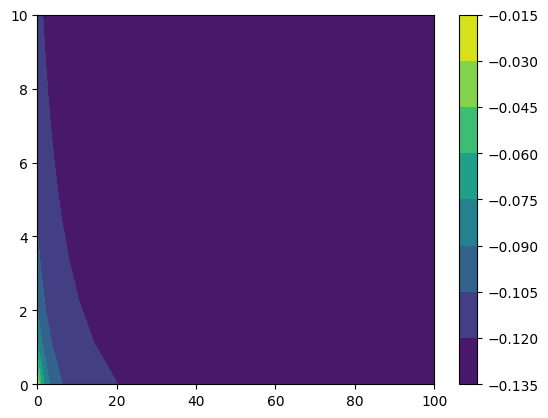

In [104]:
plt.contourf(xx,yy,z)
plt.colorbar()